In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import create_summary_stat, mcmc_diagnostics 
from downcast import downcast_df

In [2]:
def plot_prior_predictive(glm):
    # Prior
    # Plotting distribution of scores simulated from prior
    prior_samples = glm["prior_sim"].prior_predictive.sel(chain=0)
    postrr_samples = glm["postrr_sim"].posterior_predictive.sel(chain=0)
    target = "s"

    # Manipulating samples to plot
    df_prior, na_s = downcast_df(prior_samples[target].to_dataframe().reset_index())
    df_postrr, na_s = downcast_df(postrr_samples[target].to_dataframe().reset_index())

    # Joining rater/topic/model/corpus information
    data1 = data.copy()
    data1[f"{target}_dim_0"] = data1.index
    df_prior1 = pd.merge(df_prior, data1, on=target+"_dim_0", how="left")
    df_postrr1 = pd.merge(df_postrr, data1, on=target+"_dim_0", how="left")

    # Aggregating "1s" and counts by topic
    prior_agg = df_prior1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    postrr_agg = df_postrr1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    obs_agg = df_prior1[df_prior1["chain"]==0].groupby(["draw", "topic_id"]).agg({"intrusion":["sum", "count"]}).reset_index()

    # Calculating topic probabilities from sums and counts
    prior_topic_prob = prior_agg[("s","sum")]/prior_agg[("s","count")]
    postrr_topic_prob = postrr_agg[("s","sum")]/postrr_agg[("s","count")]
    obs_topic_prob = obs_agg[("intrusion","sum")]/obs_agg[("intrusion","count")]

    # Setting up plot
    plot, ax = plt.subplots(1, 1,figsize=(10,6))
    ax = az.plot_kde(np.array(prior_topic_prob), bw=0.05)
    ax.get_lines()[0].set_color("orange")
#     ax.get_lines()[0].set_linestyle("--")
#     ax = az.plot_kde(np.array(postrr_topic_prob), bw=0.05)
#     ax.get_lines()[1].set_color("green")
#     ax.get_lines()[1].set_linestyle("--")
    ax = az.plot_kde(np.array(obs_topic_prob), bw=0.05)
    ax.set_title("Prior dist: number of 1's per topic")
    ax.set_ylabel("Density")
    ax.set_xlabel("p")
    ax.legend(ax.get_lines(), ["Prior Predictive", "Observed"])

    plt.plot()

In [3]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [4]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids.index 

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [5]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array(data["topic_id"])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Models

In [8]:
# Model and MCMC specifications

n_cores = 2
emprical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 0.5
cm_lambda = 2
cm_sigma = 0.5
mu_sigma = 1

In [7]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_mean = {"model":pm.Model()}

glm_cordel = {"model":pm.Model()}
glm_rater_cordel  = {"model":pm.Model()}

glm_topic = {"model":pm.Model()}
glm_rater_topic = {"model":pm.Model()}

glm_topic_cordel = {"model":pm.Model()} # cordel contains cross join of corpus and topic 
glm_rater_topic_cordel = {"model":pm.Model()}

# glm_topic_corpora_model = {"model":pm.Model()}
# glm_rater_model_corpora = {"model":pm.Model()}

In [8]:
# Mean-only model

glm_mean["model"] = pm.Model()
with glm_mean["model"]:
    mu = pm.Normal("mu", mu=emprical_mean, sigma=mu_sigma)
    p = pm.math.invlogit(mu)
    s = pm.Bernoulli("s", p=p, observed=score_array)
    
    glm_mean["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [9]:
# cordel-only model

glm_cordel["model"] = pm.Model()
with glm_cordel["model"]:
    # Hyperparameter priors
    mu_c = pm.Normal("mu_c", mu=emprical_mean, sigma=mu_sigma)
    zc = pm.Normal("zc", mu=0, sigma=cm_sigma, shape=n_cordels)
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda) 
    
    p = pm.math.invlogit(mu_c + zc[cordel_array]*sigma_c)
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_cordel["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_c, zc, sigma_c]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
# Rater and cordel model

glm_rater_cordel["model"] = pm.Model()
with glm_rater_cordel["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=cm_sigma, shape=n_cordels)
    sigma_b = pm.Exponential("sigma_a", lam=r_lambda)
    zb = pm.Normal("za",mu=0, sigma=1, shape=n_raters)
    
    p = pm.math.invlogit(
        zb[rater_array]*sigma_b+
        zc[cordel_array]*sigma_c)
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_rater_cordel["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_c, zc, sigma_a, za]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 119 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
# Topic-only GLM

glm_topic["model"] = pm.Model()
with glm_topic["model"]:
    # Hyperparameter priors
    mu_a = pm.Normal("mu_a", mu=0, sigma=1.5)
    z_t = pm.Normal("z_t", mu=0, sigma=1, shape=n_topics)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda) 
    
    p = pm.math.invlogit(mu_a + z_t[topic_array]*sigma_a)
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_a, z_t, sigma_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.


In [12]:
# Topic-rater GLMM

glm_rater_topic["model"] = pm.Model()
with glm_rater_topic["model"]:
    # Hyperparameter priors
    mu = pm.Normal("mu", mu=0, sigma=1.5)
    z_a = pm.Normal("z_a", mu=0, sigma=1, shape=n_topics)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda) 
    z_b = pm.Normal("z_b", mu=0, sigma=1, shape=n_raters)
    sigma_b = pm.Exponential("sigma_b", lam=r_lambda)
    
    p = pm.math.invlogit(mu + z_a[topic_array]*sigma_a + z_b[rater_array]*sigma_b)
    
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_rater_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, z_a, sigma_a, z_b, sigma_b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 76 seconds.


In [13]:
# Topic and cordel model

glm_topic_cordel["model"] = pm.Model()
with glm_topic_cordel["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=cm_sigma/1.5, shape=n_cordels) #Reduces scale due to divergences
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=n_topics)
    
    p = pm.math.invlogit(za[topic_array]*sigma_a+zc[cordel_array]*sigma_c)
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_topic_cordel["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_c, zc, sigma_a, za]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 97 seconds.


In [14]:
# Rater, Topic and cordel model

glm_rater_topic_cordel["model"] = pm.Model()
with glm_rater_topic_cordel["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=cm_sigma, shape=n_cordels)
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=n_topics)
    
    p = pm.math.invlogit(
        za[topic_array]*sigma_a+
        zc[cordel_array]*sigma_c+
        zr[rater_array]*sigma_r)
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_rater_topic_cordel["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_c, zc, sigma_r, zr, sigma_a, za]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 168 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


## Diagnostics

In [78]:
# glm_mean
# glm_cordel
# glm_rater_cordel
# glm_topic
# glm_rater_topic
# glm_topic_cordel
# glm_rater_topic_cordel

glm = glm_cordel
glm

{'model': sigma_c ~ Exp(f())
      zc ~ N(1.1, 0.5)
 sigma_r ~ Exp(f())
      zr ~ N(0, 1)
 sigma_a ~ Exp(f())
      za ~ N(0, 0.5)
       s ~ Bern(f(sigma_r, zr, sigma_c, zc, sigma_a, za)),
 'trace': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data}

========================== trace diagnostics ==========================
Divergent transitions
0     0
1     1
2    30
3     9
dtype: int64


Variable with highest rhat
['zr', 117, 1.0062]


Variable with lowest effective sample size
['sigma_a', None, 978.7911]


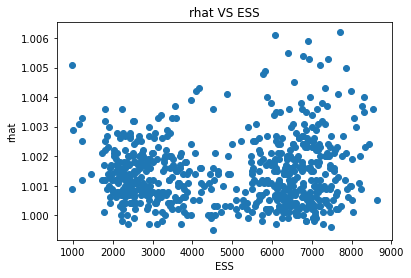

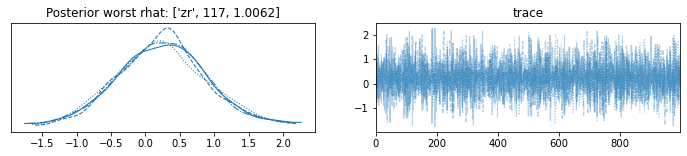

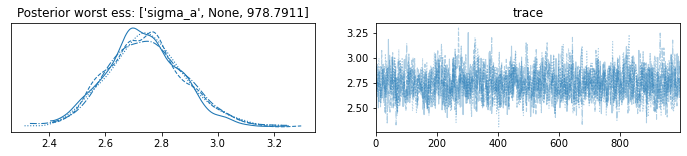

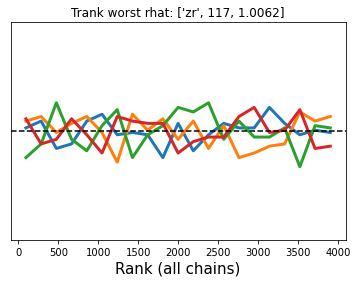

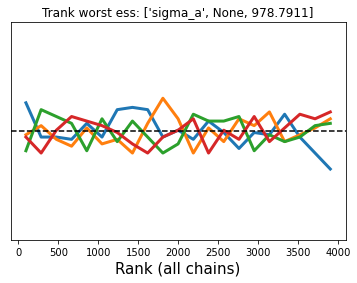

In [79]:
summary_stat = create_summary_stat(glm["trace"])
mcmc_diagnostics(glm["trace"], summary_stat)

In [82]:
summary_stat[(summary_stat["param"]!="za") & (summary_stat["param"]!="zr")]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,zc,0,1.4839,0.2719,1.0021,2.0133,0.0071,0.0050,1456.9234,1741.0921,1.0014
1,zc,1,0.8937,0.2288,0.4811,1.3539,0.0072,0.0051,990.0954,1262.8969,1.0029
2,zc,2,1.2707,0.2573,0.7872,1.7495,0.0073,0.0051,1224.3317,1419.4377,1.0025
3,zc,3,1.4286,0.2661,0.9457,1.9377,0.0075,0.0053,1236.9880,1987.1374,1.0012
4,zc,4,1.1611,0.2480,0.7305,1.6666,0.0078,0.0055,986.1748,1454.9225,1.0051
5,zc,5,1.2636,0.2516,0.8132,1.7295,0.0074,0.0052,1147.0282,1414.5339,1.0031
627,sigma_c,NaN,1.0198,0.1706,0.7300,1.3467,0.0051,0.0037,1218.6014,1384.4891,1.0033
628,sigma_r,NaN,0.5080,0.0348,0.4478,0.5783,0.0008,0.0006,1811.0375,2348.4177,1.0012
629,sigma_a,NaN,2.7436,0.1369,2.4920,3.0031,0.0044,0.0031,978.7911,1558.0358,1.0009


In [84]:
# Checking average value topic parameter value for each cordel
summary_stat["cordel"]=summary_stat["param_num"].astype(np.float32)//50
summary_stat[summary_stat["param"]=="za"].groupby("cordel").agg({"mean":"mean"})

,mean
cordel,
0.0,0.022786
1.0,-0.009970
2.0,0.012166
3.0,0.018564
4.0,0.003708
5.0,0.015164


with glm["model"]:
    glm["prior_sim"]=pm.sample_prior_predictive(1_000)
    glm["postrr_sim"]=pm.sample_posterior_predictive(glm["trace"])

plot_prior_predictive(glm)

## Model Comparison

In [15]:
models = ["glm_mean", "glm_cordel", "glm_rater_cordel", "glm_topic", 
          "glm_rater_topic", "glm_topic_cordel", "glm_rater_topic_cordel"]
comparison = az.compare({m:eval(m)["trace"] for m in models})

In [16]:
comparison.to_csv("model_comparison.csv")

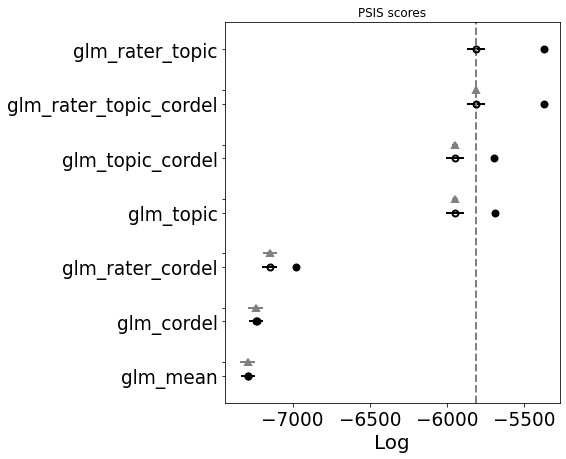

In [18]:
ax = az.plot_compare(comparison)
ax.set_title("PSIS scores")
plt.show()

In [19]:
comparison

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
glm_rater_topic,0,-5811.333323,440.250290,0.000000,9.055932e-01,58.099703,0.000000,False,log
glm_rater_topic_cordel,1,-5812.520549,440.580951,1.187226,3.836451e-07,58.089208,1.004092,False,log
glm_topic_cordel,2,-5950.703737,256.365607,139.370414,7.008396e-03,58.060815,18.929506,False,log
glm_topic,3,-5950.914689,257.211176,139.581366,8.739905e-02,58.160529,18.981578,False,log
glm_rater_cordel,4,-7147.078942,170.263917,1335.745620,4.190957e-08,48.037358,47.035202,False,log
glm_cordel,5,-7237.729246,5.875869,1426.395923,4.819692e-09,46.555168,48.091830,False,log
glm_mean,6,-7290.355186,1.056301,1479.021863,0.000000e+00,45.912411,48.991250,False,log


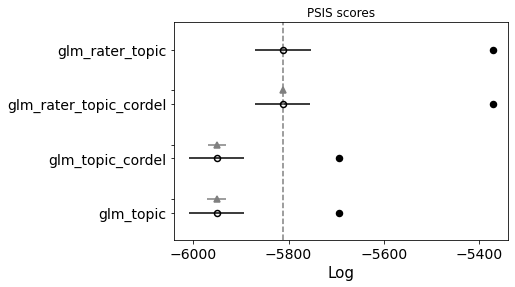

In [21]:
ax = az.plot_compare(comparison.iloc[:4])
ax.set_title("PSIS scores")
plt.show()